**08_NWT_02 - Newton-Raphson** **- IMS**

In [1]:
import os ; import flopy ; import matplotlib.pyplot as plt ; from matplotlib.colors import ListedColormap ; from pathlib import Path
from flopy.plot.styles import styles ; import pandas as pd ; import numpy as np 
from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE",True);run=get_env("RUN",True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

In [2]:
sim_name = "08_p02" ; output_folder = Path("./08_ex-gwf-nwt-p02") ; output_folder.mkdir(exist_ok=True)  ;gwf_name = sim_name 
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'                ; workspace = figs_path = output_folder 

In [3]:
parameters = {"08_p02a": {"newton": "newton"},                                                     # 1 ,2 
              "08_p02b": {"rewet": True,"wetfct": 0.5,"iwetit": 1,"ihdwet": 1,"wetdry"  : -0.5}}     
length_units="feet"; nper = 4 ;  nlay = 14  ; nrow = 40 ;ncol = 40    ;delr = 125    ;  delc = 125   ;top = 80 ;  k11 = 5 ;k33 = 0.25   
time_units="days"  ; ss = 0.0002 ; sy = 0.2 ;  H1 = 25  ;rech = 0.05  ;nouter = 500  ;  ninner = 100 ;hclose = 0.000001   ;rclose = 1000   
tdis_ds = ((190.0, 10, 1.0),(518.0, 2, 1.0),(1921.0, 17, 1.0),(1.0, 1, 1.0))  ; extents = (0, delr * ncol, 20, 65)
shape3d = (nlay, nrow, ncol)     ; botm = np.arange(65.0, -5.0, -5.0)  ; icelltype = 9 * [1] + 5 * [0]  ; chd_spd = []
for k in range(9, nlay, 1):
    chd_spd += [[k, i, ncol - 1, H1] for i in range(nrow - 1)] ; chd_spd += [[k, nrow - 1, j, H1] for j in range(ncol)]
rch_spd = []
for i in range(0, 2, 1):
    for j in range(0, 2, 1):
        rch_spd.append([0, i, j, rech])

In [5]:
def build_models(name, newton=False, rewet=False, wetfct=None, iwetit=None, ihdwet=None, wetdry=None):



    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation (sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis  (sim  ,nper=nper, perioddata=tdis_ds, time_units=time_units)
    if newton: newtonoptions = "newton" ; no_ptc = "ALL"  ; complexity = "complex"               # 1  A 1,2  
    else:      newtonoptions = None     ; no_ptc = None   ; complexity = "simple"                # 2  B 1,2 .. = 4
    flopy.mf6.ModflowIms   (sim  ,print_option="SUMMARY",                                    complexity=complexity ,no_ptcrecord = no_ptc, 
                            outer_maximum=nouter ,inner_maximum=ninner ,outer_dvclose=hclose ,inner_dvclose=hclose ,rcloserecord=rclose)
    gwf = flopy.mf6.ModflowGwf   (sim, modelname=sim_name, newtonoptions=newtonoptions)
    flopy.mf6.ModflowGwfdis (gwf ,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    if rewet:  rewet_record  = ["wetfct", wetfct, "iwetit", iwetit, "ihdwet", ihdwet] ; wetdry = 9 * [wetdry] + 5 * [0]
    else:      rewet_record  = None
    flopy.mf6.ModflowGwfnpf (gwf ,rewet_record=rewet_record,icelltype=icelltype,k=k11,k33=k33,wetdry=wetdry)
    flopy.mf6.ModflowGwfsto (gwf ,iconvert=icelltype,ss=ss,sy=sy,steady_state={3: True})
    flopy.mf6.ModflowGwfic  (gwf ,strt=H1)
    flopy.mf6.ModflowGwfchd (gwf ,stress_period_data=chd_spd)
    flopy.mf6.ModflowGwfrch (gwf ,stress_period_data=rch_spd)
    head_filerecord = f"{sim_name}.hds"
    flopy.mf6.ModflowGwfoc  (gwf ,head_filerecord=head_filerecord,saverecord=[("HEAD", "ALL")]) 
    return sim
def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent) ; assert success, buff
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]   ; params = parameters[key].copy()  ; sim = build_models(key, **params)
    if write: write_models (sim, silent=silent)
    if run:   run_models   (sim, silent=silent)
scenario(0)  ; scenario(1)

run_models took 9056.19 ms
run_models took 3988.27 ms


In [11]:
sim  = flopy.mf6.MFSimulation.load(sim_ws=os.path.join (workspace, '08_p02a') , exe_name=exe_name ,verbosity_level=0)  # Load Newton
gwf =sim .get_model(sim_name) ; bot=gwf.dis.botm.array   ; hobj =gwf .output.head() ; times=hobj.get_times() ; xnode = gwf.modelgrid.xcellcenters[0, :]
head2a  = hobj.get_data()  ; amax = np.amax(head2a, axis=0)  ; sa = pd.DataFrame(amax) ;  print(amax.shape)  # axis 0 (z)
def get_water_table(h, bot):
    imask = (h > -1e30) & (h <= bot) ; h[imask] = -1e30            ; return np.amax(h, axis=0)
head2a2a = get_water_table(head2a, bot)

(40, 40)


In [12]:
sim  = flopy.mf6.MFSimulation.load(sim_ws=os.path.join (workspace, '08_p02b') , exe_name=exe_name ,verbosity_level=0)  # Load Newton
gwf =sim .get_model(sim_name) ; bot=gwf.dis.botm.array   ; hobj =gwf .output.head() ; times=hobj.get_times()
head2b  = hobj.get_data()  ; amax = np.amax(head2b, axis=0)  ; sa = pd.DataFrame(amax) ;  print(amax.shape)  # axis 0 (z)
def get_water_table(h, bot):
    imask = (h > -1e30) & (h <= bot) ; h[imask] = -1e30            ; return np.amax(h, axis=0)
head2b2b = get_water_table(head2b, bot)

(40, 40)


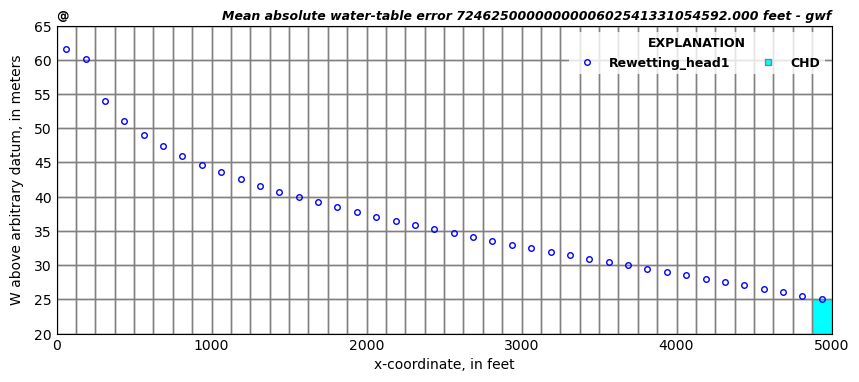

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))                                     ; ax.set_xlim(extents[:2])  ; ax.set_ylim(extents[2:])   
diff = np.abs(head2a - head2a2a)    ; me = diff.sum()/float(ncol * nrow)         ; me_text = f"Mean absolute water-table error {me:.3f} feet - gwf"
nn = flopy.plot.PlotCrossSection(model=gwf ,extent=extents ,line={"row": 1} , ax=ax)  ; nn.plot_bc("CHD",color='cyan')  ; lc = nn.plot_grid() 

ax.plot(xnode ,head2a    [0, :]  ,lw=0.75     , color="black"                       )  #  ,label="Newton-Raphson_head"
ax.plot(xnode ,head2a2a [0, :] ,lw=0,marker="o" ,ms=4       ,mfc="none",mec="blue" ,label="Rewetting_head1")
ax.plot(-1000,-1000,lw=0   ,marker="s"  ,ms=4,mec="0.5" ,mfc="none")
ax.plot(-1000,-1000,lw=0   ,marker="s"  ,ms=4,mec="0.5" ,mfc="cyan"            ,label="CHD")
styles.graph_legend(ax     ,loc="upper right",ncol=2    ,frameon=True ,facecolor="white" ,edgecolor="none")

letter = chr(ord("@") ) ; styles.heading(letter=letter, ax=ax)  
styles.add_text(ax, text=me_text, x=1, y=1.01, ha="right", bold=True) ; styles.remove_edge_ticks(ax) ; ax.set_ylabel(" ")
        
ax.set_xlabel(" ") ; ax = fig.add_subplot(1, 1, 1, frameon=False)
ax.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off") ; ax.set_xlim(0, 1) ; ax.set_xticks([0, 1])
ax.set_xlabel("x-coordinate, in feet") ; ax.set_ylabel("W above arbitrary datum, in meters") ; styles.remove_edge_ticks(ax) ; plt.show()

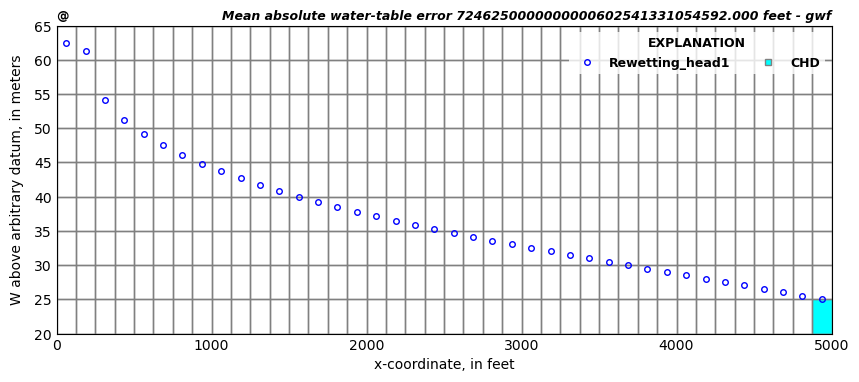

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))                                     ; ax.set_xlim(extents[:2])  ; ax.set_ylim(extents[2:])   
diff = np.abs(head2a - head2a2a)    ; me = diff.sum()/float(ncol * nrow)         ; me_text = f"Mean absolute water-table error {me:.3f} feet - gwf"
nn = flopy.plot.PlotCrossSection(model=gwf ,extent=extents ,line={"row": 1} , ax=ax)  ; nn.plot_bc("CHD",color='cyan')  ; lc = nn.plot_grid() 

ax.plot(xnode ,head2b    [0, :]  ,lw=0.75     , color="black"           ) #  ,label="Newton-Raphson_head"
ax.plot(xnode ,head2b2b [0, :] ,lw=0,marker="o" ,ms=4       ,mfc="none",mec="blue" ,label="Rewetting_head1")
ax.plot(-1000,-1000,lw=0   ,marker="s"  ,ms=4,mec="0.5" ,mfc="none")
ax.plot(-1000,-1000,lw=0   ,marker="s"  ,ms=4,mec="0.5" ,mfc="cyan"            ,label="CHD")
styles.graph_legend(ax     ,loc="upper right",ncol=2    ,frameon=True ,facecolor="white" ,edgecolor="none")

letter = chr(ord("@") ) ; styles.heading(letter=letter, ax=ax)  
styles.add_text(ax, text=me_text, x=1, y=1.01, ha="right", bold=True) ; styles.remove_edge_ticks(ax) ; ax.set_ylabel(" ")
        
ax.set_xlabel(" ") ; ax = fig.add_subplot(1, 1, 1, frameon=False)
ax.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off") ; ax.set_xlim(0, 1) ; ax.set_xticks([0, 1])
ax.set_xlabel("x-coordinate, in feet") ; ax.set_ylabel("W above arbitrary datum, in meters") ; styles.remove_edge_ticks(ax) ; plt.show()

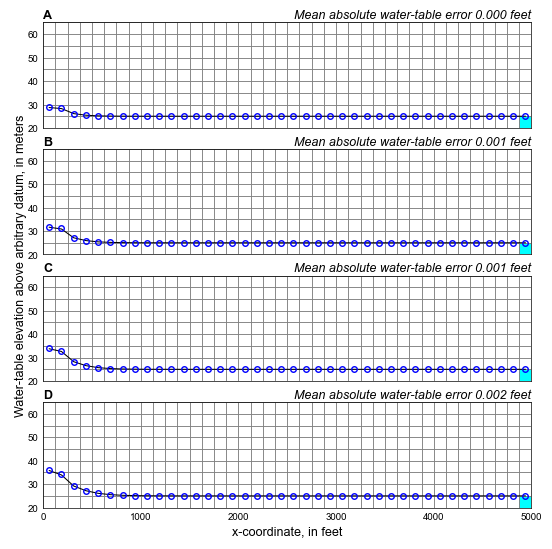

In [16]:
figure_size = (6.3, 6.3)  ; masked_values = (1e30, -1e30)
def get_water_table(h, bot):
    imask = (h > -1e30) & (h <= bot)
    h[imask] = -1e30
    return np.amax(h, axis=0)
def plot_results(silent=True):
    if not plot:
        return

    verbose = not silent
    if verbose:
        verbosity_level = 1
    else:
        verbosity_level = 0

    with styles.USGSMap():
        name = next(iter(parameters.keys()))  ; sim_ws = os.path.join(workspace, name)
        sim = flopy.mf6.MFSimulation.load(sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity_level)
        gwf = sim.get_model(sim_name) ; bot = gwf.dis.botm.array  ; xnode = gwf.modelgrid.xcellcenters[0, :]  ; hobj = gwf.output.head()
        times = hobj.get_times()

        name = list(parameters.keys())[1]     ; sim_ws = os.path.join(workspace, name)
        sim1 = flopy.mf6.MFSimulation.load(sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity_level)
        gwf1 = sim1.get_model(sim_name)  ; hobj1 = gwf1.output.head()

        # Create figure for simulation
        fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=figure_size, constrained_layout=False)

        for idx, ax in enumerate(axes):
            head = hobj.get_data(totim=times[idx])
            head = get_water_table(head, bot)

            head1 = hobj1.get_data(totim=times[idx])
            head1 = get_water_table(head1, bot)

            # calculate mean error
            diff = np.abs(head - head1)
            # print("max", diff.max(), np.argmax(diff))
            me = diff.sum() / float(ncol * nrow)
            me_text = f"Mean absolute water-table error {me:.3f} feet"

            ax.set_xlim(extents[:2])
            ax.set_ylim(extents[2:])
            mm = flopy.plot.PlotCrossSection(model=gwf, ax=ax, extent=extents, line={"row": 1}) ; mm.plot_bc("CHD", color="cyan")
            mm.plot_grid(lw=0.5)  ; ax.plot(xnode, head[0, :], lw=0.75, color="black", label="Newton-Raphson")
            ax.plot(xnode,head1[0, :],lw=0,marker="o",ms=4,mfc="none",mec="blue",label="Rewetting")
            letter = chr(ord("@") + idx + 1)
            styles.heading(letter=letter, ax=ax)
            styles.add_text(ax, text=me_text, x=1, y=1.01, ha="right", bold=False)
            styles.remove_edge_ticks(ax)

            # set fake y-axis label
            ax.set_ylabel(" ")

        # set fake x-axis label
        ax.set_xlabel(" ")

        ax = fig.add_subplot(1, 1, 1, frameon=False)
        ax.tick_params(
            labelcolor="none", top="off", bottom="off", left="off", right="off"
        )
        ax.set_xlim(0, 1)
        ax.set_xticks([0, 1])
        ax.set_xlabel("x-coordinate, in feet")
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 1])
        ax.set_ylabel("Water-table elevation above arbitrary datum, in meters")
        styles.remove_edge_ticks(ax)

        if plot_show:
            plt.show()
if plot:
    plot_results()